## Data

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
GSPC = yf.download("^GSPC", start="1999-04-01", end="2019-10-09", interval = "1d")
VIX = yf.download("^VIX", start="1999-04-01", end="2019-10-09", interval = "1d")

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [3]:
GSPC_Close = GSPC[['Close']].values.astype(float)
VIX_Close = VIX[['Close']].values.astype(float)

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
GSPC_scaled = min_max_scaler.fit_transform(GSPC_Close)
VIX_scaled = min_max_scaler.fit_transform(VIX_Close)

In [4]:
clean_data = pd.DataFrame(index=GSPC.index, data=GSPC_scaled, columns=['S&P500'])
clean_data['VIX'] = VIX_scaled

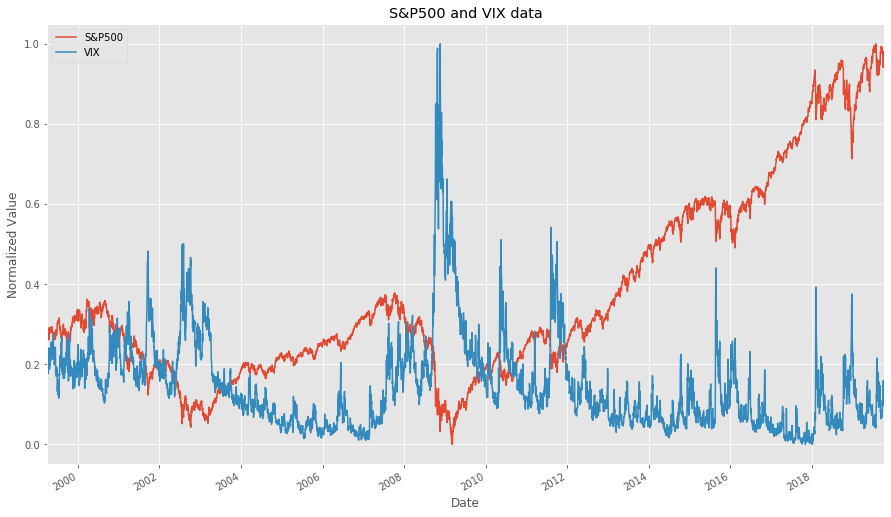

In [5]:
# Closing value of the S&P500 and VIX.
ax = clean_data.plot(figsize=(15,9), title = 'S&P500 and VIX data')
_ = ax.set_ylabel("Normalized Value")

In [6]:
train_GSPC_up = GSPC.loc['20030214':'20071009']
train_GSPC_down = GSPC.loc['20000901':'20030213']
test_GSPC_up = GSPC.loc['20090409':'20100326']
test_GSPC_down = GSPC.loc['20071009':'20080926']

train_VIX_up = VIX.loc['20030214':'20071009']
train_VIX_down = VIX.loc['20000901':'20030213']
test_VIX_up = VIX.loc['20090409':'20100326']
test_VIX_down = VIX.loc['20071009':'20080926']

## Quantitative Algorithms

In [7]:
def RSI(df, column="Close", period=14):
    # Wilder's RSI
    delta = df[column].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    rUp = up.ewm(com=period - 1, adjust=False).mean()
    rDown = down.ewm(com=period - 1, adjust=False).mean().abs()
    rsi = 100 - 100 / (1 + rUp / rDown)
    df = df.join(rsi.to_frame('RSI'))
    df['RSI_p1'] = df['RSI'].shift()
    df['RSI_p2'] = df['RSI_p1'].shift()
    return df

In [8]:
def MACD(df, column="Close", fast=12, slow=26, line=9):
    exp1 = df[column].ewm(span=fast, adjust=False).mean()
    exp2 = df[column].ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    exp3 = macd.ewm(span=9, adjust=False).mean()
    df = df.join(macd.to_frame('MACD'))
    df['MACD_p1'] = df['MACD'].shift()
    df['MACD_p2'] = df['MACD_p1'].shift()
    return df

In [9]:
def ml_input(df, trend='up', types='train'):
    df1 = RSI(df)[['RSI', 'RSI_p1', 'RSI_p2']]
    df2 = MACD(df)[['MACD', 'MACD_p1', 'MACD_p2']]
    if trend=='up' and types =='train':
        df3 = train_VIX_up['Close']
    if trend=='down' and types =='train':
        df3 = train_VIX_down['Close']
    if trend=='up' and types =='test':
        df3 = test_VIX_up['Close']
    if trend=='down' and types =='test':
        df3 = test_VIX_down['Close']
    df1 = df1.join(df2)
    df1 = df1.join(df3)
    df1.rename(columns={"Close": "VIX"},inplace=True)
    df1['VIX_p1'] = df1['VIX'].shift()
    df1['VIX_p2'] = df1['VIX_p1'].shift()
    df1['S&P_change'] = df['Close'].diff()
    
    df1.drop(index=df1.index[:26], inplace=True)
    df1.drop(index=df1.index[-5:], inplace=True)

    return df1

In [10]:
def ml_output(data, shift_forward=5):
    df = data.copy()
    diff = (df['Close'].shift(-shift_forward) - df['Close'])
    df['Trading Signal'] = -1
    df.loc[diff>=0, 'Trading Signal'] = 1
    
    df.drop(index=df.index[:26], inplace=True)
    df.drop(index=df.index[-5:], inplace=True)
    
    return df[['Trading Signal']]

In [11]:
def rsi_cal(row):
    if row['RSI']<30:
        order = 1
    elif row['RSI']>70:
        order = -1
    else:
        order = 0
    return order

def macd_cal(row):
    if row['MACD']>0:
        order = 1
    elif row['MACD']<0:
        order = -1
    else:
        order = 0
    return order

def mom_cal(row):
    if row['Mom']<15:
        order = 1
    elif row['Mom']>85:
        order = -1
    else:
        order = 0
    return order


In [12]:
X_train_up = ml_input(train_GSPC_up, trend='up', types='train')
y_train_up = ml_output(train_GSPC_up)

X_test_up = ml_input(test_GSPC_up, trend='up', types='test')
y_test_up = ml_output(test_GSPC_up)

X_train_down = ml_input(train_GSPC_down, trend='down', types='train')
y_train_down = ml_output(train_GSPC_down)

X_test_down = ml_input(test_GSPC_down, trend='down', types='test')
y_test_down = ml_output(test_GSPC_down)

## Up Trend

### Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
n_trees = 100

rf = RandomForestClassifier(n_estimators=n_trees, max_depth=3, random_state=42)

In [15]:
rf.fit(X_train_up.values, y_train_up.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [16]:
X_train_up_pred_rf = rf.predict(X_train_up.values)

X_test_up_pred_rf = rf.predict(X_test_up.values)

In [17]:
prob = rf.predict_proba(X_train_up.values)

In [18]:
rf.classes_

array([-1,  1])

### SVM

In [19]:
from sklearn.svm import SVC

In [20]:
kernel = 'rbf'
C = 100
gamma = 0.0001

svm = SVC(kernel=kernel, C=C, gamma=gamma, probability=True)

In [21]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(X_train_up.values)
distances = np.column_stack([np.sum((X_train_up.values - center)**2, axis=1)**0.5 for center in kmeans.cluster_centers_])

In [22]:
svm.fit(distances, y_train_up.values.ravel())

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [23]:
kmeans = KMeans(n_clusters=6).fit(X_test_up.values)
distances = np.column_stack([np.sum((X_test_up.values - center)**2, axis=1)**0.5 for center in kmeans.cluster_centers_])

In [24]:
X_test_up_pred_svm = svm.predict(distances)

### Other indicators

In [25]:
X_up = X_test_up.copy(deep=True)

In [26]:
test_GSPC_up.loc[:,'Close_p12'] = test_GSPC_up['Close'].shift(12)
test_GSPC_up.loc[:,'Mom'] = test_GSPC_up['Close']-test_GSPC_up['Close_p12']
test_GSPC_up.drop(index=test_GSPC_up.index[:26], inplace=True)
test_GSPC_up.drop(index=test_GSPC_up.index[-5:], inplace=True)

/Users/victor/anaconda3/envs/py37tf2/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/victor/anaconda3/envs/py37tf2/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/victor/anaconda3/envs/py37tf2/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [27]:
X_up['RSI_order'] = X_up.apply(rsi_cal, axis=1)
X_up['MACD_order'] = X_up.apply(macd_cal, axis=1)
X_up['Mom_order'] = test_GSPC_up.apply(mom_cal, axis=1)

In [28]:
X_up.describe()

,RSI,RSI_p1,RSI_p2,MACD,MACD_p1,MACD_p2,VIX,VIX_p1,VIX_p2,S&P_change,RSI_order,MACD_order,Mom_order
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,57.522228,57.439924,57.348275,8.101091,8.074270,8.055637,24.123585,24.199764,24.269340,1.306698,-0.089623,0.660377,0.433962
std,9.640769,9.613645,9.537998,8.331176,8.314085,8.299904,3.772035,3.789917,3.785496,11.096311,0.286316,0.752711,0.533590
min,33.301494,33.301494,33.301494,-14.388915,-14.388915,-14.388915,16.620000,16.620000,16.910000,-34.170000,-1.000000,-1.000000,-1.000000
25%,51.804318,51.804318,51.804318,3.683327,3.683327,3.683327,21.490000,21.565000,21.597500,-3.532500,0.000000,1.000000,0.000000
50%,58.791758,58.686446,58.597220,9.467833,9.467833,9.467833,24.255000,24.275000,24.295000,2.425000,0.000000,1.000000,0.000000
75%,64.131724,63.864467,63.769829,14.220439,14.150272,14.003161,26.127500,26.190000,26.230000,7.670000,0.000000,1.000000,1.000000
max,75.801736,75.801736,75.801736,23.131008,23.131008,23.131008,32.680000,33.120000,33.120000,26.840000,0.000000,1.000000,1.000000


In [29]:
X_up.head(10)

,RSI,RSI_p1,RSI_p2,MACD,MACD_p1,MACD_p2,VIX,VIX_p1,VIX_p2,S&P_change,RSI_order,MACD_order,Mom_order
Date,,,,,,,,,,,,,
2009-05-18,59.433990,51.914669,55.545751,11.086005,10.522713,12.382472,30.24,33.12,31.37,26.83,0,1,0
2009-05-19,58.850362,59.433990,51.914669,11.274954,11.086005,10.522713,28.80,30.24,33.12,-1.58,0,1,0
2009-05-20,57.070340,58.850362,59.433990,10.922764,11.274954,11.086005,29.03,28.80,30.24,-4.66,0,1,1
2009-05-21,51.608692,57.070340,58.850362,9.314606,10.922764,11.274954,31.35,29.03,28.80,-15.14,0,1,1
2009-05-22,51.145638,51.608692,57.070340,7.842408,9.314606,10.922764,32.63,31.35,29.03,-1.33,0,1,1
2009-05-26,58.226109,51.145638,51.608692,8.460686,7.842408,9.314606,30.62,32.63,31.35,23.33,0,1,1
2009-05-27,52.195587,58.226109,51.145638,7.471010,8.460686,7.842408,32.36,30.62,32.63,-17.27,0,1,1
2009-05-28,56.099770,52.195587,58.226109,7.708945,7.471010,8.460686,31.67,32.36,30.62,13.77,0,1,1
2009-05-29,59.299892,56.099770,52.195587,8.789504,7.708945,7.471010,28.92,31.67,32.36,12.31,0,1,1


### Backtester

In [30]:
initial_cap = 10000
commission = 0.0035

In [31]:
def backtester(prices, orders, trend='up', initial_cap=initial_cap, commission=commission):
    position = 0
    shares = 0
    capital = initial_cap
    capital_list = []
    
    if trend == 'up':

        for order, price in zip(orders, prices):
            if order == 1 and position == 0:
                position = 1
                capital = capital * (1 - commission)
                shares = capital / price[0]
            elif order == -1 and position == 1:
                position = 0
                capital = shares * price[0] * (1 - commission)
                shares = 0
            else:
                position = position
                shares = shares
                if shares != 0:
                    capital = shares * price[1]
                else:
                    capital = capital
                
#             if order == 1 and position == 0:
#                 position = 1
#                 capital = capital * (1 - commission)
#                 shares = capital / price[0]

#             elif order == 1 and position == 1:
#                 capital = shares * price[1]

#             elif order == -1 and position == 1:
#                 position = 0
#                 capital = shares * price[1] * (1 - commission)
#                 shares = 0

#             elif order == -1 and position == 0:
#                 capital = capital

            capital_list.append(capital)
    
    if trend == 'down':

        for order, price in zip(orders, prices):

            if order == -1 and position == 0:
                position = -1
                shares = capital / price[0]
                stock_values = shares * price[0] * (1 - commission)
                capital = capital + stock_values - shares * price[1]
                price_p = price[1]

            elif order == -1 and position == -1:
                #stocks_value = shares * price[1]
                #capital = capital + stock_values - shares * price[1]
                capital = capital - shares * (price[1]-price_p)
                price_p = price[1]
                shares = shares

            elif order == 1 and position == -1:
                position = 0
                stock_values = shares * price[0] * (1 - commission)
                #capital = capital + stock_values - shares * price[1]
                capital = capital + stock_values - shares * price[0]
                shares = 0
                price_p = price[1]

            elif order == 1 and position == 0:
                position = 1
                capital = capital * (1 - commission)
                shares = capital / price[0]
                price_p = price[1]
                
            elif order == -1 and position == 1:
                position = 0
                capital = shares * price[0] * (1 - commission)
                shares = 0
                price_p = price[1]
            else:
                position = position
                shares = shares
                if position > 0:
                    capital = shares * price[1]
                else:
                    capital = capital
                price_p = price[1]

            capital_list.append(capital)
    
    return capital_list

In [32]:
prices = test_GSPC_up[['Open', 'Close']]
prices.drop(index=prices.index[:26], inplace=True)
prices.drop(index=prices.index[-5:], inplace=True)

In [33]:
rf_orders_up = X_test_up_pred_rf
svm_orders_up = X_test_up_pred_svm

In [34]:
rsi_orders_up = X_up['RSI_order'].values
macd_orders_up = X_up['MACD_order'].values
mom_orders_up = X_up['Mom_order'].values

In [35]:
rf_capitals_up = backtester(prices.values, rf_orders_up, trend='up')
svm_capitals_up = backtester(prices.values, svm_orders_up, trend='up')

In [36]:
mom_capitals_up = backtester(prices.values, mom_orders_up, trend='up')
macd_capitals_up = backtester(prices.values, macd_orders_up, trend='up')
rsi_capitals_up = backtester(prices.values, rsi_orders_up, trend='up')

In [37]:
BH_capitals_up = backtester(prices.values, np.ones(rf_orders_up.shape), trend='up')

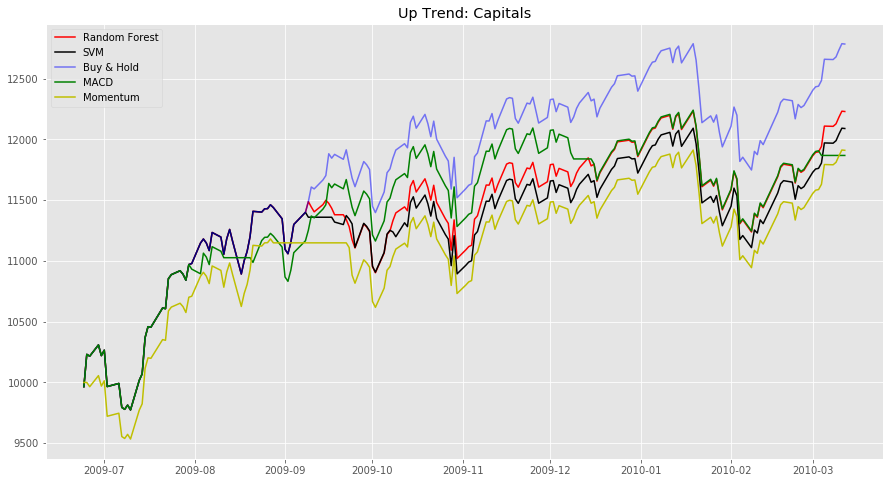

In [38]:
_ = plt.figure(figsize=(15,8))
_ = plt.plot(prices.index, rf_capitals_up, label='Random Forest', color='r')
_ = plt.plot(prices.index, svm_capitals_up, label='SVM', color='k')
_ = plt.plot(prices.index, BH_capitals_up, label='Buy & Hold', color='b', alpha=0.5)
_ = plt.plot(prices.index, macd_capitals_up, label='MACD', color='g')
_ = plt.plot(prices.index, mom_capitals_up, label='Momentum', color='y')
_ = plt.title('Up Trend: Capitals')
_ = plt.legend()

## Down Trend

### Random Forest

In [39]:
rf = RandomForestClassifier(n_estimators=n_trees, max_depth=3, random_state=42)
rf.fit(X_train_down.values, y_train_down.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [40]:
X_train_down_pred_rf = rf.predict(X_train_down.values)
X_test_down_pred_rf = rf.predict(X_test_down.values)

In [41]:
prob = rf.predict_proba(X_train_down.values)

### SVM

In [42]:
svm = SVC(kernel=kernel, C=C, gamma=gamma, probability=True)

In [43]:
kmeans = KMeans(n_clusters=6).fit(X_train_down.values)
distances = np.column_stack([np.sum((X_train_down.values - center)**2, axis=1)**0.5 for center in kmeans.cluster_centers_])

In [44]:
svm.fit(distances, y_train_down.values.ravel())

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [45]:
kmeans = KMeans(n_clusters=6).fit(X_test_down.values)
distances = np.column_stack([np.sum((X_test_down.values - center)**2, axis=1)**0.5 for center in kmeans.cluster_centers_])

In [46]:
X_test_down_pred_svm = svm.predict(distances)

### Other indicators

In [47]:
X_down = X_test_down.copy(deep=True)
test_GSPC_down.loc[:,'Close_p12'] = test_GSPC_down['Close'].shift(12)
test_GSPC_down.loc[:,'Mom'] = test_GSPC_down['Close']-test_GSPC_down['Close_p12']
test_GSPC_down.drop(index=test_GSPC_down.index[:26], inplace=True)
test_GSPC_down.drop(index=test_GSPC_down.index[-5:], inplace=True)

/Users/victor/anaconda3/envs/py37tf2/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/victor/anaconda3/envs/py37tf2/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/victor/anaconda3/envs/py37tf2/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [48]:
X_down['RSI_order'] = X_down.apply(rsi_cal, axis=1)
X_down['MACD_order'] = X_down.apply(macd_cal, axis=1)
# X_down['Mom_order'] = test_GSPC_down.apply(mom_cal, axis=1)

### Backtester

In [49]:
prices = test_GSPC_down[['Open', 'Close']]
prices.drop(index=prices.index[:26], inplace=True)
prices.drop(index=prices.index[-5:], inplace=True)

In [50]:
rf_orders_down = X_test_down_pred_rf
svm_orders_down = X_test_down_pred_svm

In [53]:
macd_orders_down = X_down['MACD_order'].values
mom_orders_down = X_down['Mom_order'].values

KeyError: 'Mom_order'

In [52]:
mom_capitals_down = backtester(prices.values, mom_orders_down, trend='down')
macd_capitals_down = backtester(prices.values, macd_orders_down, trend='down')

NameError: name 'mom_orders_down' is not defined

In [54]:
rf_capitals_down = backtester(prices.values, rf_orders_down, trend='down')
svm_capitals_down = backtester(prices.values, svm_orders_down, trend='down')

In [55]:
BH_capitals_down = backtester(prices.values, np.ones(rf_orders_down.shape), trend='down')

NameError: name 'macd_capitals_down' is not defined

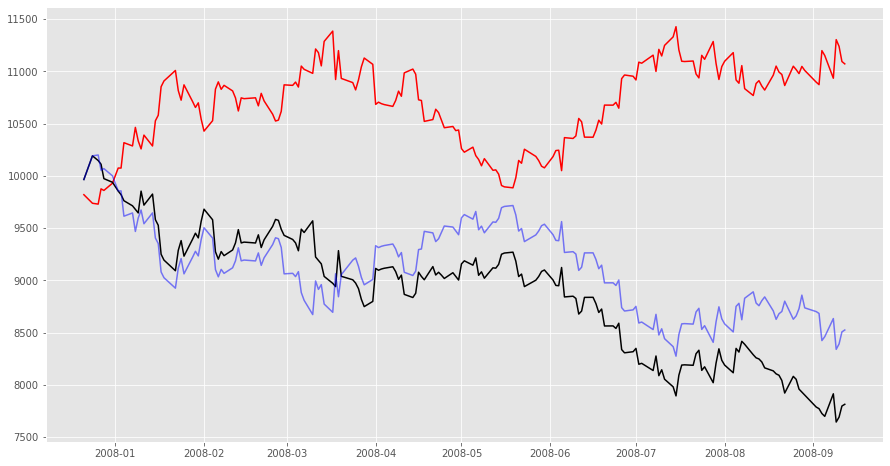

In [56]:
_ = plt.figure(figsize=(15,8))
_ = plt.plot(prices.index, rf_capitals_down, label='Random Forest', color='r')
_ = plt.plot(prices.index, svm_capitals_down, label='SVM', color='k')
_ = plt.plot(prices.index, BH_capitals_down, label='Buy & Hold', color='b', alpha=0.5)
_ = plt.plot(prices.index, macd_capitals_down, label='MACD', color='g')
_ = plt.plot(prices.index, mom_capitals_down, label='Momentum', color='y')
_ = plt.title('Down Trend: Capitals')
_ = plt.legend()

## Statistics Analysis

In [64]:
def AnnualizedReturn(capitals):

    cumulative_return = (capitals[-1] - initial_cap) / initial_cap
    days_held = len(capitals)
    annualized_return = (1 + cumulative_return)**(365 / days_held) - 1
    
    return annualized_return

In [65]:
def AnnualizedVolatility(capitals):

    daily_returns = np.diff(capitals) / capitals[1:]
    sigma = np.std(daily_returns)
    annualized_volatility = sigma * np.sqrt(252)
    
    return annualized_volatility

In [66]:
def SharpeRatio(capitals):
    
    sharpe_ratio = AnnualizedReturn(capitals) / AnnualizedVolatility(capitals)
    
    return sharpe_ratio

In [67]:
def MaxDrawdown(capitals):
    
    cap = pd.Series(capitals)
    max_drawdown = ((cap.cummax() - cap) / cap.cummax()).max()
    
    return max_drawdown

In [68]:
def CalulateStatistics(capitals, name='StrategyName'):
    
    ret = AnnualizedReturn(capitals)
    vol = AnnualizedVolatility(capitals)
    sharpe = SharpeRatio(capitals)
    drawdown = MaxDrawdown(capitals)
    
    df = pd.DataFrame([[ret*100, vol*100, sharpe, drawdown*100]], 
                      columns=['Annualized Return(%)', 'Annualized Volatility(%)', 'Sharpe Ratio', 'Max Drawdown(%)'], 
                      index=[name])
    
    return df

### Up Trend

In [69]:
stat_svm_up = CalulateStatistics(svm_capitals_up, 'SVM')
stat_rf_up = CalulateStatistics(rf_capitals_up, 'Random Forest')
stat_bh_up = CalulateStatistics(BH_capitals_up, 'Buy & Hold')
stat_macd_up = CalulateStatistics(macd_capitals_up, 'MACD')
stat_mom_up = CalulateStatistics(mom_capitals_up, 'Momentum')

In [70]:
pd.concat([stat_svm_up, stat_rf_up,
           stat_bh_up, stat_macd_up, stat_mom_up])

,Annualized Return(%),Annualized Volatility(%),Sharpe Ratio,Max Drawdown(%)
SVM,46.629032,16.637077,2.802718,8.12794
Random Forest,50.072305,16.596499,3.017040,8.12794
Buy & Hold,64.132648,16.727051,3.834068,8.12794
MACD,41.257844,16.084505,2.565068,8.12794
Momentum,42.272754,16.014689,2.639624,8.12794


In [ ]:
initial_cap = 10000
commission = 0.0035

In [ ]:
position = 0
shares = 0
capital = initial_cap
capital_list = []

for order, price in zip(orders, prices):
    
    if order == 1 and position == 0:
        position = 1
        capital = capital * (1 - commission)
        shares = capital / price[0]
    
    elif order == 1 and position == 1:
        capital = shares * price[1]
        
    elif order == -1 and position == 1:
        position = 0
        capital = shares * price[1] * (1 - commission)
        shares = 0
  
    elif order == -1 and position == 0:
        capital = capital
    
    capital_list.append(capital)

In [ ]:
capital

In [ ]:
position = 0
shares = 0
capital = initial_cap
capital_list = []

for order, price in zip(orders, prices):
    
    if order == -1 and position == 0:
        position = -1
        shares = capital / price[0]
        stock_values = shares * price[0] * (1 - commission)
        capital = capital + stock_values - shares * price[0]
    
    elif order == -1 and position == -1:
        stocks_value = shares * price[1]
        capital = capital + stock_values - shares * price[1]
        
    elif order == 1 and position == -1:
        position = 0
        stock_values = shares * price[1] * (1 - commission)
        capital = capital + stock_values - shares * price[1]
        shares = 0
  
    elif order == 1 and position == 0:
        capital = capital
    
    capital_list.append(capital)

In [ ]:
capital

In [ ]:
plt.plot(capital_list)